In [1]:
import pandas as pd
import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

import cartopy.crs as ccrs
import random
import pooch
import os
import tempfile

In [2]:
def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/Heatwaves' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file
# @title Figure settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}
%matplotlib inline

In [4]:
# loading CMIP data

col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ["MPI-ESM1-2-LR"]


# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

# Initial Explorations
(can ignore)

In [5]:
cat = col.search(
    source_id=source_ids,
    variable_id="tas",
    member_id="r1i1p1f1",
    table_id="3hr",
    grid_label="gn",
    experiment_id=["historical"],  # add scenarios if interested in projection
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)
cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt = cat.to_datatree(**kwargs)

tas_all = dt["MPI-ESM1-2-LR"]["historical"].ds.tas

# define a 'target' grid. This is simply a regular lon/lat grid that we will interpolate our data on
ds_target = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(0, 360, 1.0), {"units": "degrees_east"}),
    }
)  # you can try to modify the parameters above to e.g. just regrid onto a region or make the resolution coarser etc

# define the regridder object (from our source dataarray to the target)
regridder = xe.Regridder(
    tas_all, ds_target, "bilinear", periodic=True
)  # this takes some time to calculate a weight matrix for the regridding
regridder


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_192x96_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (192, 96) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [6]:
tas_all_r = regridder(tas_all)

In [7]:
tas_china = tas_all_r.sel(lon=slice(78,126), lat=slice(19,43))
tas_china_2013 = tas_china.sel(time = "2013-01-01T00:00:00").squeeze()
tas_china_2013

<xarray.DataArray (lat: 25, lon: 49)>
dask.array<getitem, shape=(25, 49), dtype=float32, chunksize=(25, 49), chunktype=numpy.ndarray>
Coordinates:
    height          float64 2.0
    time            object 2013-01-01 00:00:00
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
  * lat             (lat) float64 19.0 20.0 21.0 22.0 ... 40.0 41.0 42.0 43.0
  * lon             (lon) float64 78.0 79.0 80.0 81.0 ... 124.0 125.0 126.0
Attributes:
    regrid_method:  bilinear

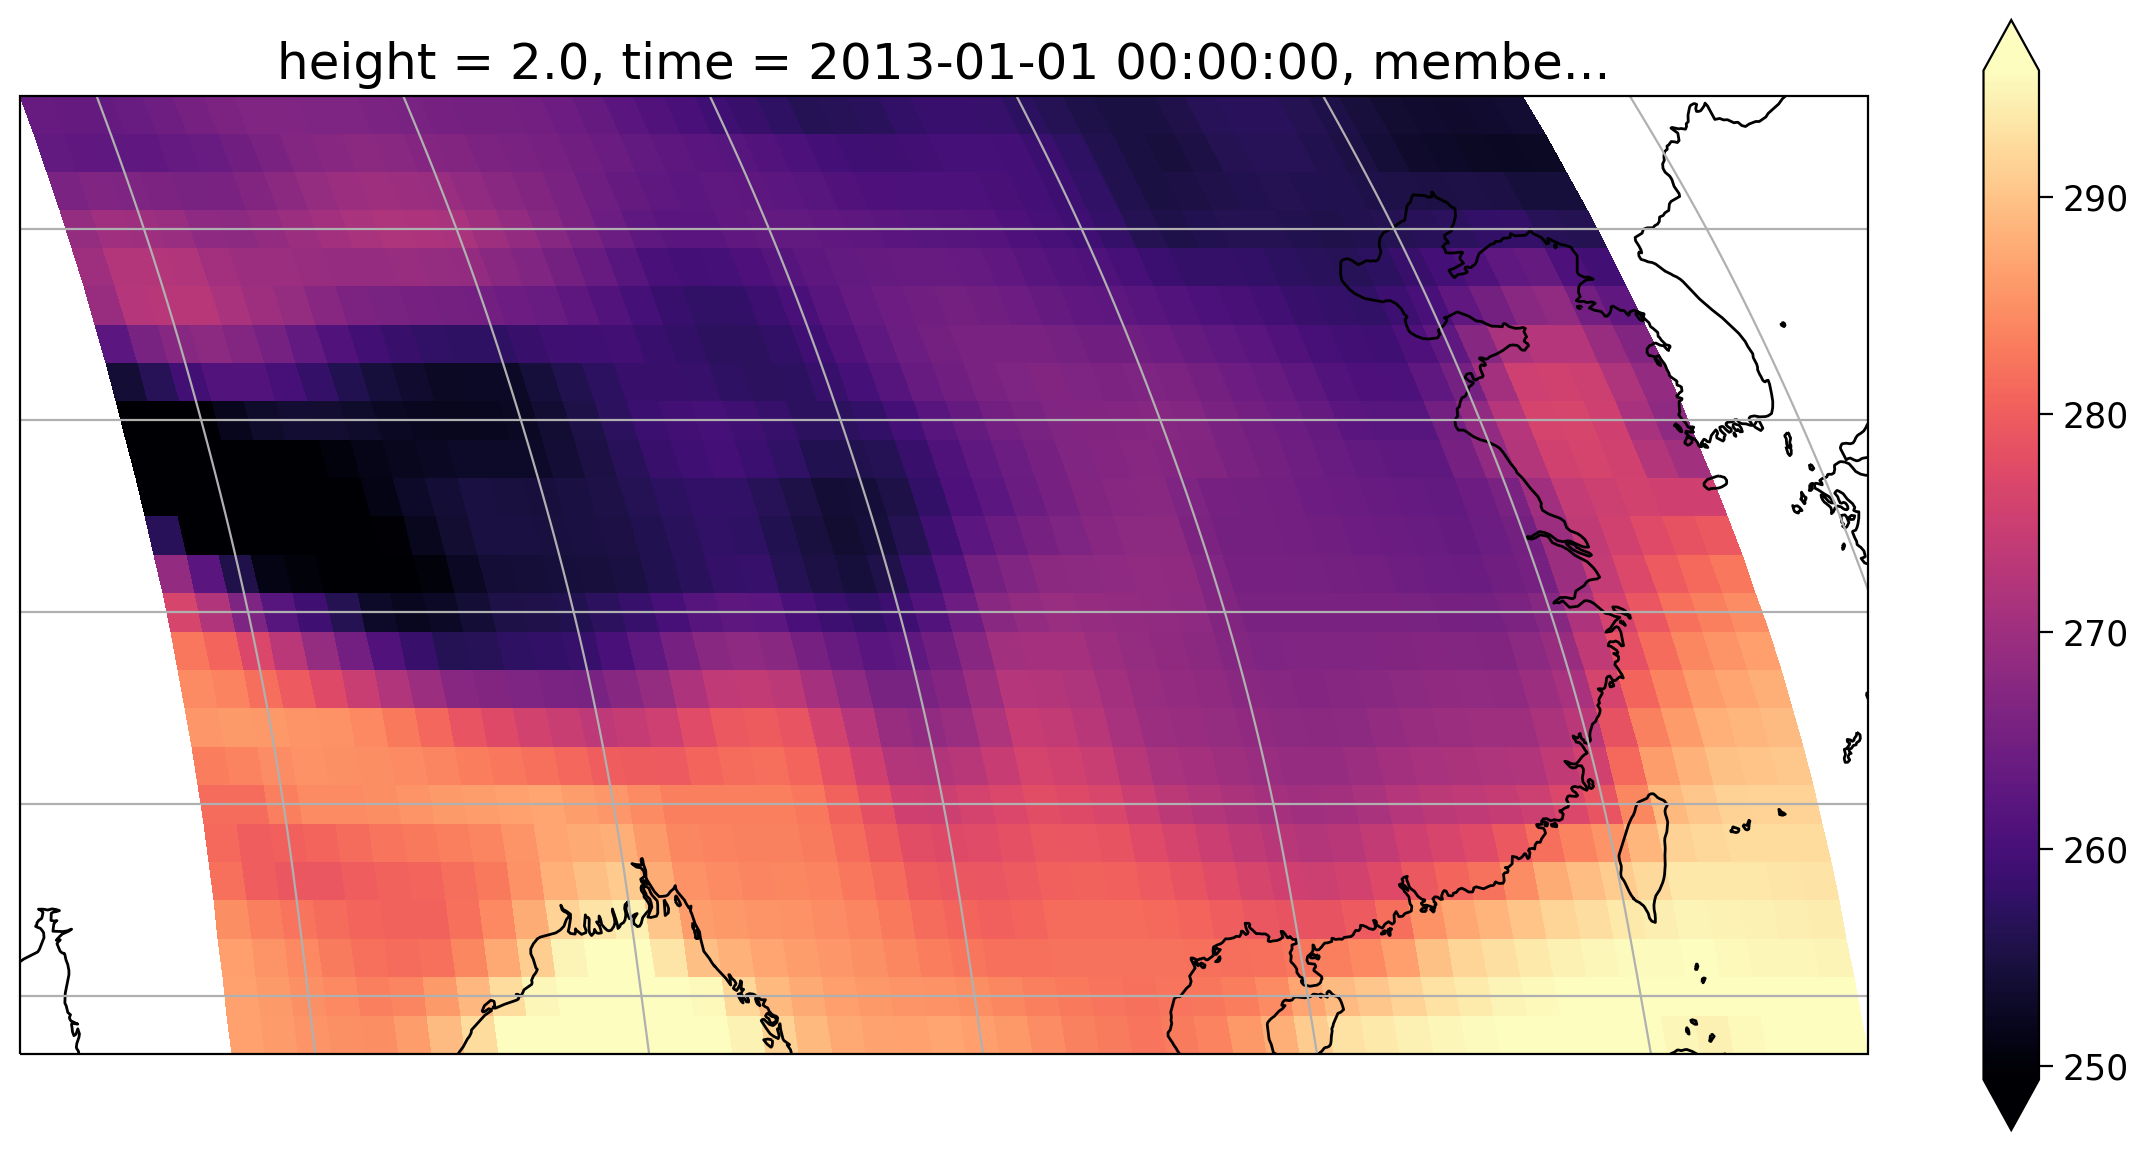

In [8]:
fig, ax_china = plt.subplots(
    figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)
tas_china_2013.plot(ax=ax_china, transform=ccrs.PlateCarree(), cmap="magma", robust=True)
ax_china.coastlines()
ax_china.gridlines()

In [ ]:
fig, ax_present = plt.subplots(
    figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)

# plot a timestep for July 1, 2013
tas_present = tas_all.sel(time="2013-07-01T00").squeeze()
tas_present.plot(ax=ax_present, transform=ccrs.PlateCarree(), cmap="magma", robust=True)
ax_present.coastlines()
ax_present.set_title("July, 1st 2013")

# Albedo

In [5]:
catrad = col.search(
    source_id="CESM2",
    variable_id=["rsds", "rsus", "tas"],
    member_id="r1i1p1f1",
    table_id="day",
    grid_label="gn",
    experiment_id=["historical"],
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)
# create data tree
# catrad.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dtrad = catrad.to_datatree(**kwargs)
dtrad


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id/institution_id/source_id/experiment_id/table_id/grid_label'


DataTree('None', parent=None)
└── DataTree('CMIP')
    └── DataTree('NCAR')
        └── DataTree('CESM2')
            └── DataTree('historical')
                └── DataTree('day')
                    └── DataTree('gn')
                            Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 60226, y: 192,
                                                 x: 288, nbnd: 2)
                            Coordinates:
                              * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
                              * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
                              * time            (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
                                time_bounds     (time, nbnd) object dask.array<chunksize=(30113, 1), meta=np.ndarray>
                                lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
                                lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
                              * nbnd            (nbnd) int64 0 1
                                lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
                                lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
                              * member_id       (member_id) object 'r1i1p1f1'
                              * dcpp_init_year  (dcpp_init_year) float64 nan
                            Data variables:
                                rsds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 654, 192, 288), meta=np.ndarray>
                                rsus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 341, 192, 288), meta=np.ndarray>
                                tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 397, 192, 288), meta=np.ndarray>
                            Attributes: (12/53)
                                Conventions:                      CF-1.7 CMIP-6.2
                                activity_id:                      CMIP
                                branch_method:                    standard
                                branch_time_in_child:             674885.0
                                branch_time_in_parent:            219000.0
                                case_id:                          15
                                ...                               ...
                                intake_esm_attrs:member_id:       r1i1p1f1
                                intake_esm_attrs:table_id:        day
                                intake_esm_attrs:grid_label:      gn
                                intake_esm_attrs:version:         20190308
                                intake_esm_attrs:_data_format_:   zarr
                                intake_esm_dataset_key:           CMIP/NCAR/CESM2/historical/day/gn

In [115]:
# get dataset from data tree
dsrad = dtrad["CMIP"]["NCAR"]["CESM2"]["historical"]["day"]["gn"].to_dataset().squeeze()
# calculate albedo
dsrad["Albedo"] = dsrad.rsus / dsrad.rsds
dsrad

<xarray.Dataset>
Dimensions:         (time: 60226, y: 192, x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    time_bounds     (time, nbnd) object dask.array<chunksize=(30113, 1), meta=np.ndarray>
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
Data variables:
    rsds            (time, y, x) float32 dask.array<chunksize=(654, 192, 288), meta=np.ndarray>
    rsus            (time, y, x) float32 dask.array<chunksize=(341, 192, 288), meta=np.ndarray>
    tas             (time, y, x) float32 dask.array<chunksize=(397, 192, 288), meta=np.ndarray>
    Albedo          (time, y, x) float32 dask.array<chunksize=(341, 192, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            219000.0
    case_id:                          15
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190308
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP/NCAR/CESM2/historical/day/gn

In [10]:
# # regrid data son lon and lat can be used 
# # define a 'target' grid. This is simply a regular lon/lat grid that we will interpolate our data on
# ds_target = xr.Dataset(
#     {
#         "lat": (["lat"], np.arange(-90, 90, 1.0), {"units": "degrees_north"}),
#         "lon": (["lon"], np.arange(0, 360, 1.0), {"units": "degrees_east"}),
#     }
# )  # you can try to modify the parameters above to e.g. just regrid onto a region or make the resolution coarser etc

# # define the regridder object (from our source dataarray to the target)
# regridder = xe.Regridder(
#     dsrad, ds_target, "bilinear", periodic=True
# )  # this takes some time to calculate a weight matrix for the regridding
# dsreg = regridder(dsrad)
# dsreg

<xarray.Dataset>
Dimensions:         (time: 1980, lat: 180, lon: 360, bnds: 2)
Coordinates:
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
    height          float64 2.0
  * lat             (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * lon             (lon) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
Dimensions without coordinates: bnds
Data variables:
    rsds            (time, lat, lon) float32 dask.array<chunksize=(358, 180, 360), meta=np.ndarray>
    rsus            (time, lat, lon) float32 dask.array<chunksize=(345, 180, 360), meta=np.ndarray>
    tas             (time, lat, lon) float32 dask.array<chunksize=(600, 180, 360), meta=np.ndarray>
    alb             (time, lat, lon) float32 dask.array<chunksize=(345, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [11]:
# # get tas and alb for all locations
# tas_all = dsreg.tas
# alb_all = dsreg.alb
# alb_all

<xarray.DataArray 'alb' (time: 1980, lat: 180, lon: 360)>
dask.array<_regrid, shape=(1980, 180, 360), dtype=float32, chunksize=(345, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
    height          float64 2.0
  * lat             (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * lon             (lon) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0

In [117]:
tas_all = dsrad.tas
alb_all = dsrad.Albedo
alb_all

<xarray.DataArray 'Albedo' (time: 60226, y: 192, x: 288)>
dask.array<truediv, shape=(60226, 192, 288), dtype=float32, chunksize=(341, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan

In [118]:
tasch = tas_all.sel(x = slice(78, 126), y = slice(19,43)).squeeze()
albch = alb_all.sel(x = slice(78, 126), y = slice(19,43)).squeeze()

In [119]:
albchina_2014 = alb_all.sel(x = slice(78, 126), y = slice(19,43), time="2014-07-16").squeeze()
albchina_2014

<xarray.DataArray 'Albedo' (y: 26, x: 38)>
dask.array<getitem, shape=(26, 38), dtype=float32, chunksize=(26, 38), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 19.32 20.26 21.2 22.15 ... 40.99 41.94 42.88
  * x               (x) float64 78.75 80.0 81.25 82.5 ... 122.5 123.8 125.0
    time            object 2014-07-16 00:00:00
    lon             (x, y) float64 78.75 78.75 78.75 78.75 ... 125.0 125.0 125.0
    lat             (x, y) float64 19.32 20.26 21.2 22.15 ... 40.99 41.94 42.88
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


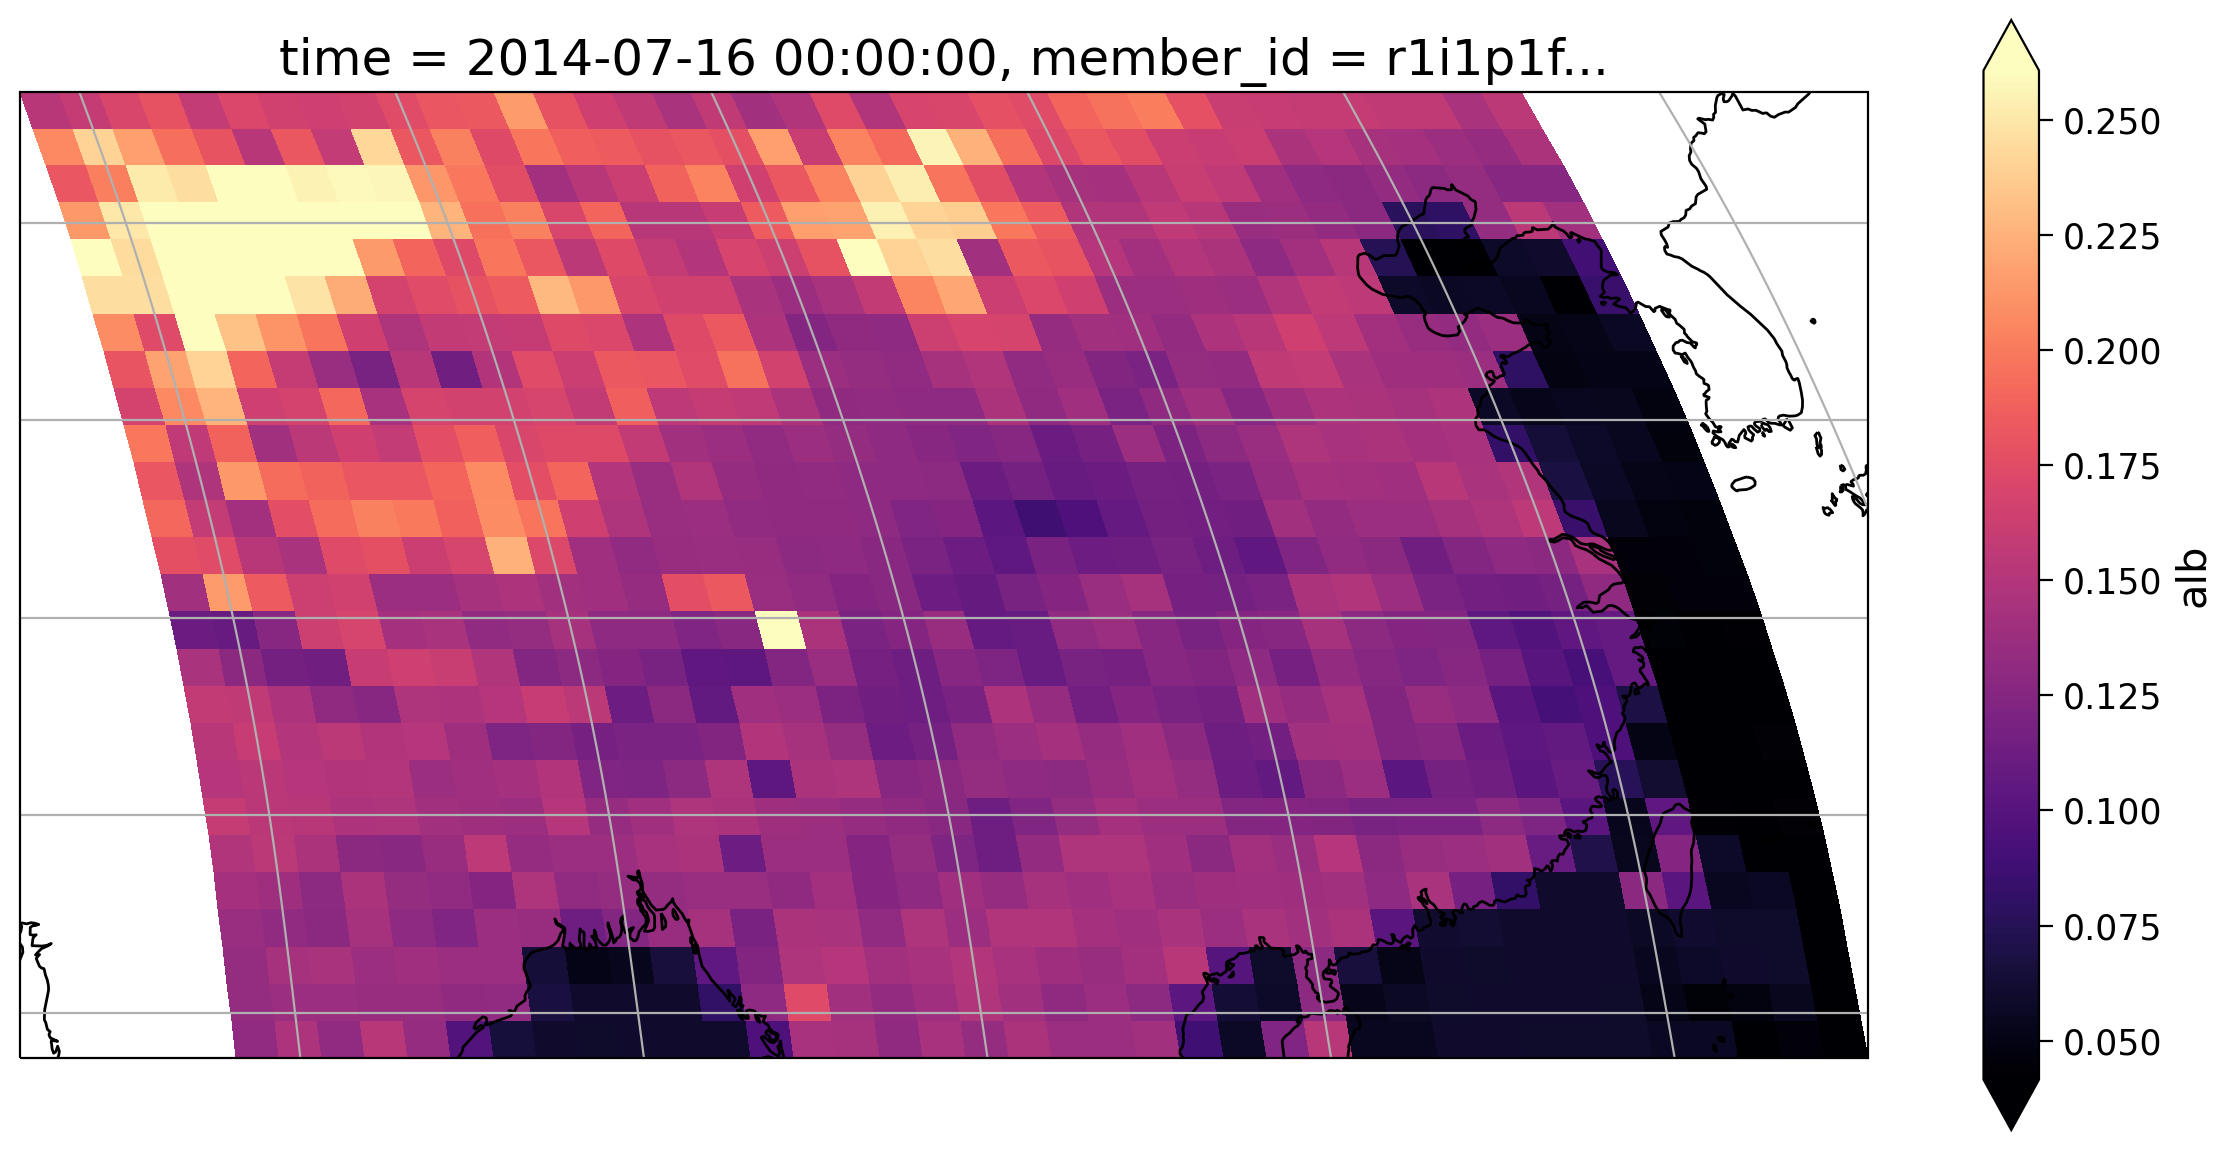

In [54]:
fig, ax_albchina = plt.subplots(
    figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)
albchina_2014.plot(ax=ax_albchina, transform=ccrs.PlateCarree(), cmap="magma", robust=True)
ax_albchina.coastlines()
ax_albchina.gridlines()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


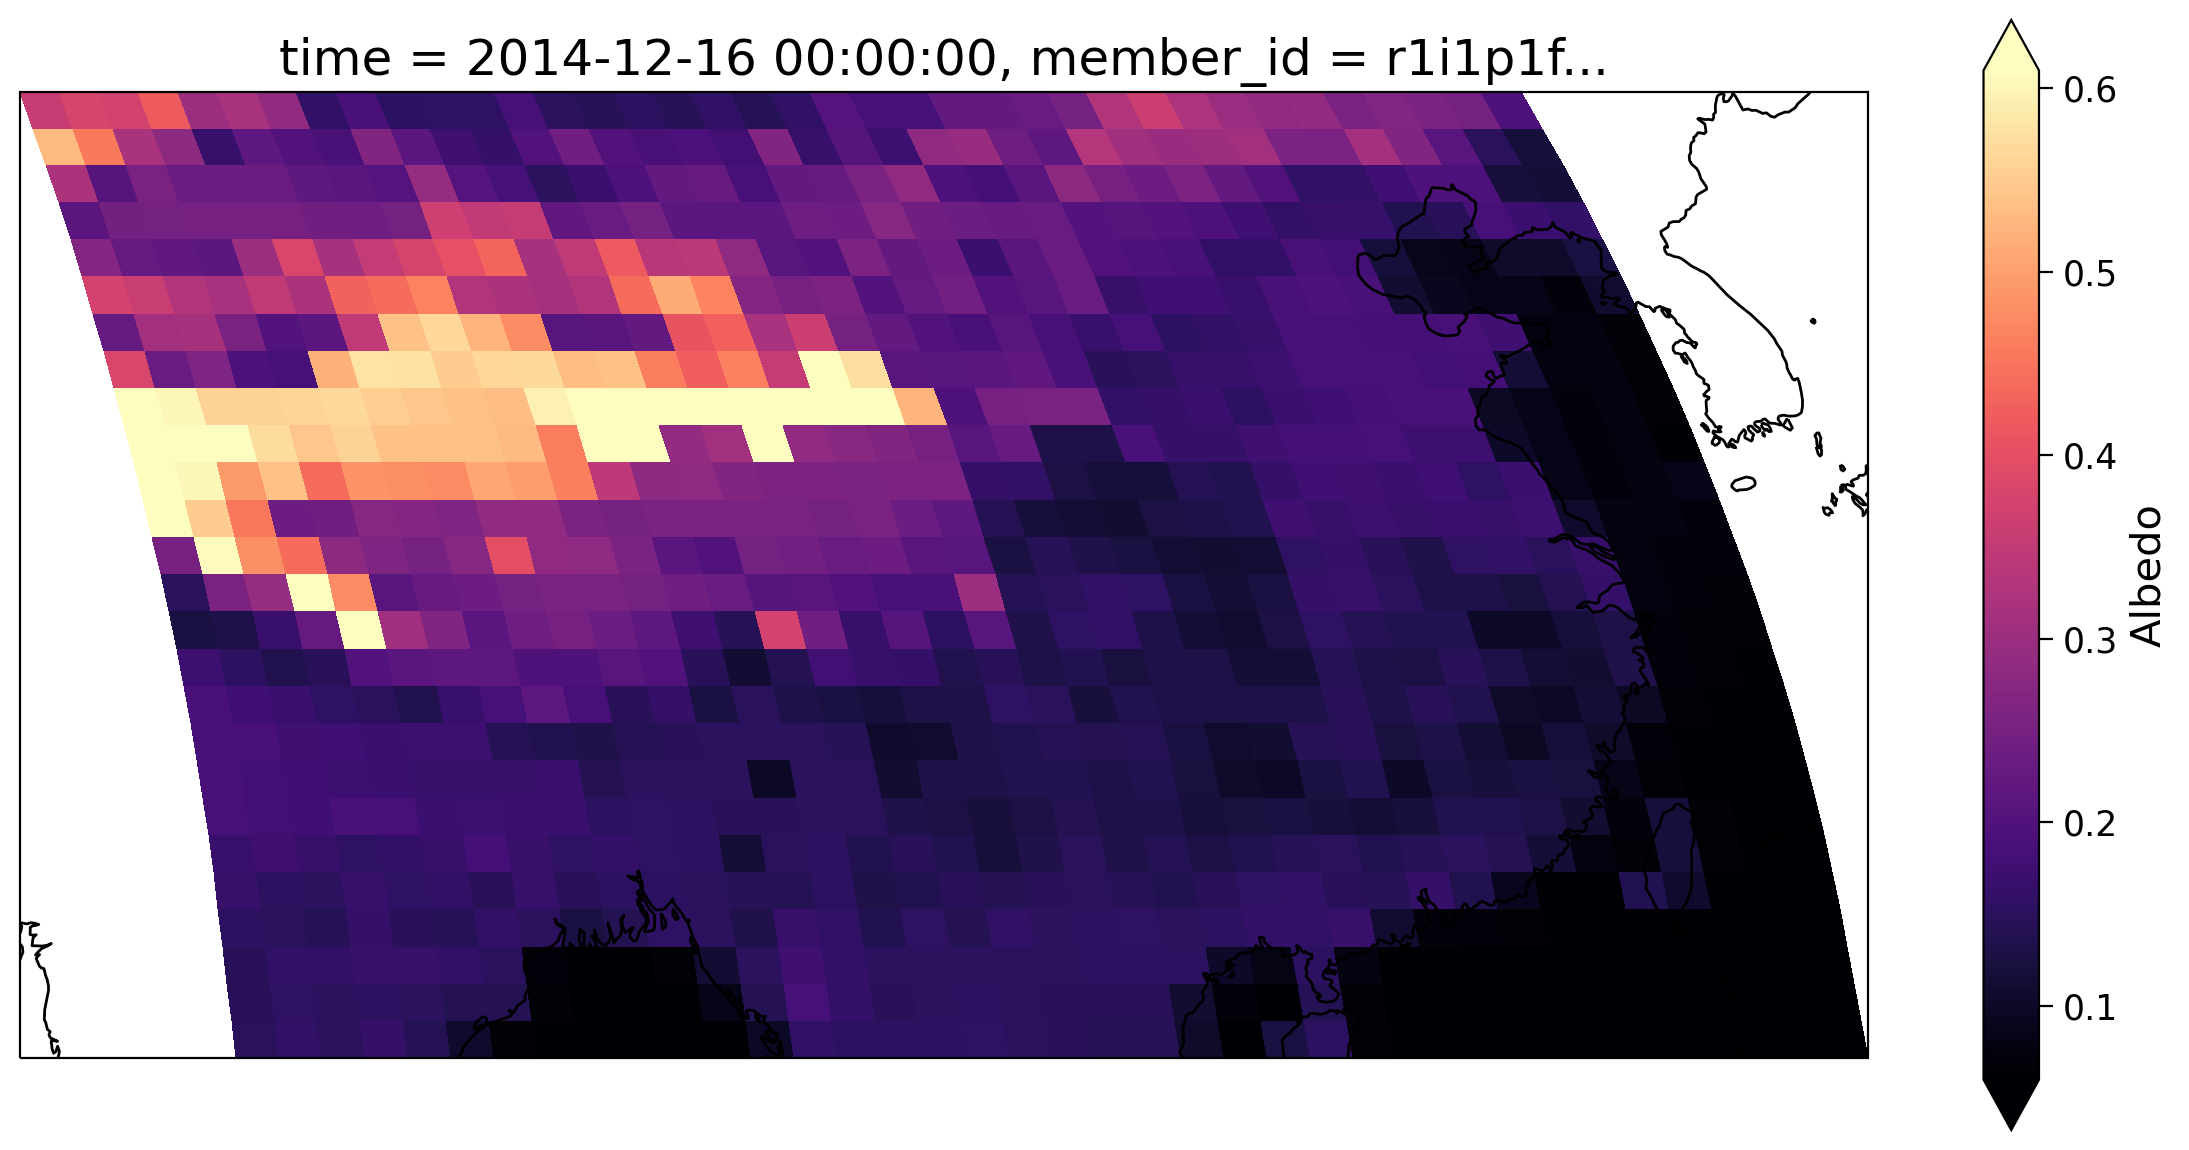

In [121]:
# trying to plot alb
albchina_2014 = alb_all.sel(x=slice(78,126), y=slice(19,43),time="2014-12-16").squeeze()
# alb_all.time

fig, ax_albchina = plt.subplots(
    figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)
albchina_2014.plot(ax=ax_albchina, transform=ccrs.PlateCarree(), cmap="magma", robust=True)
ax_albchina.coastlines()


/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


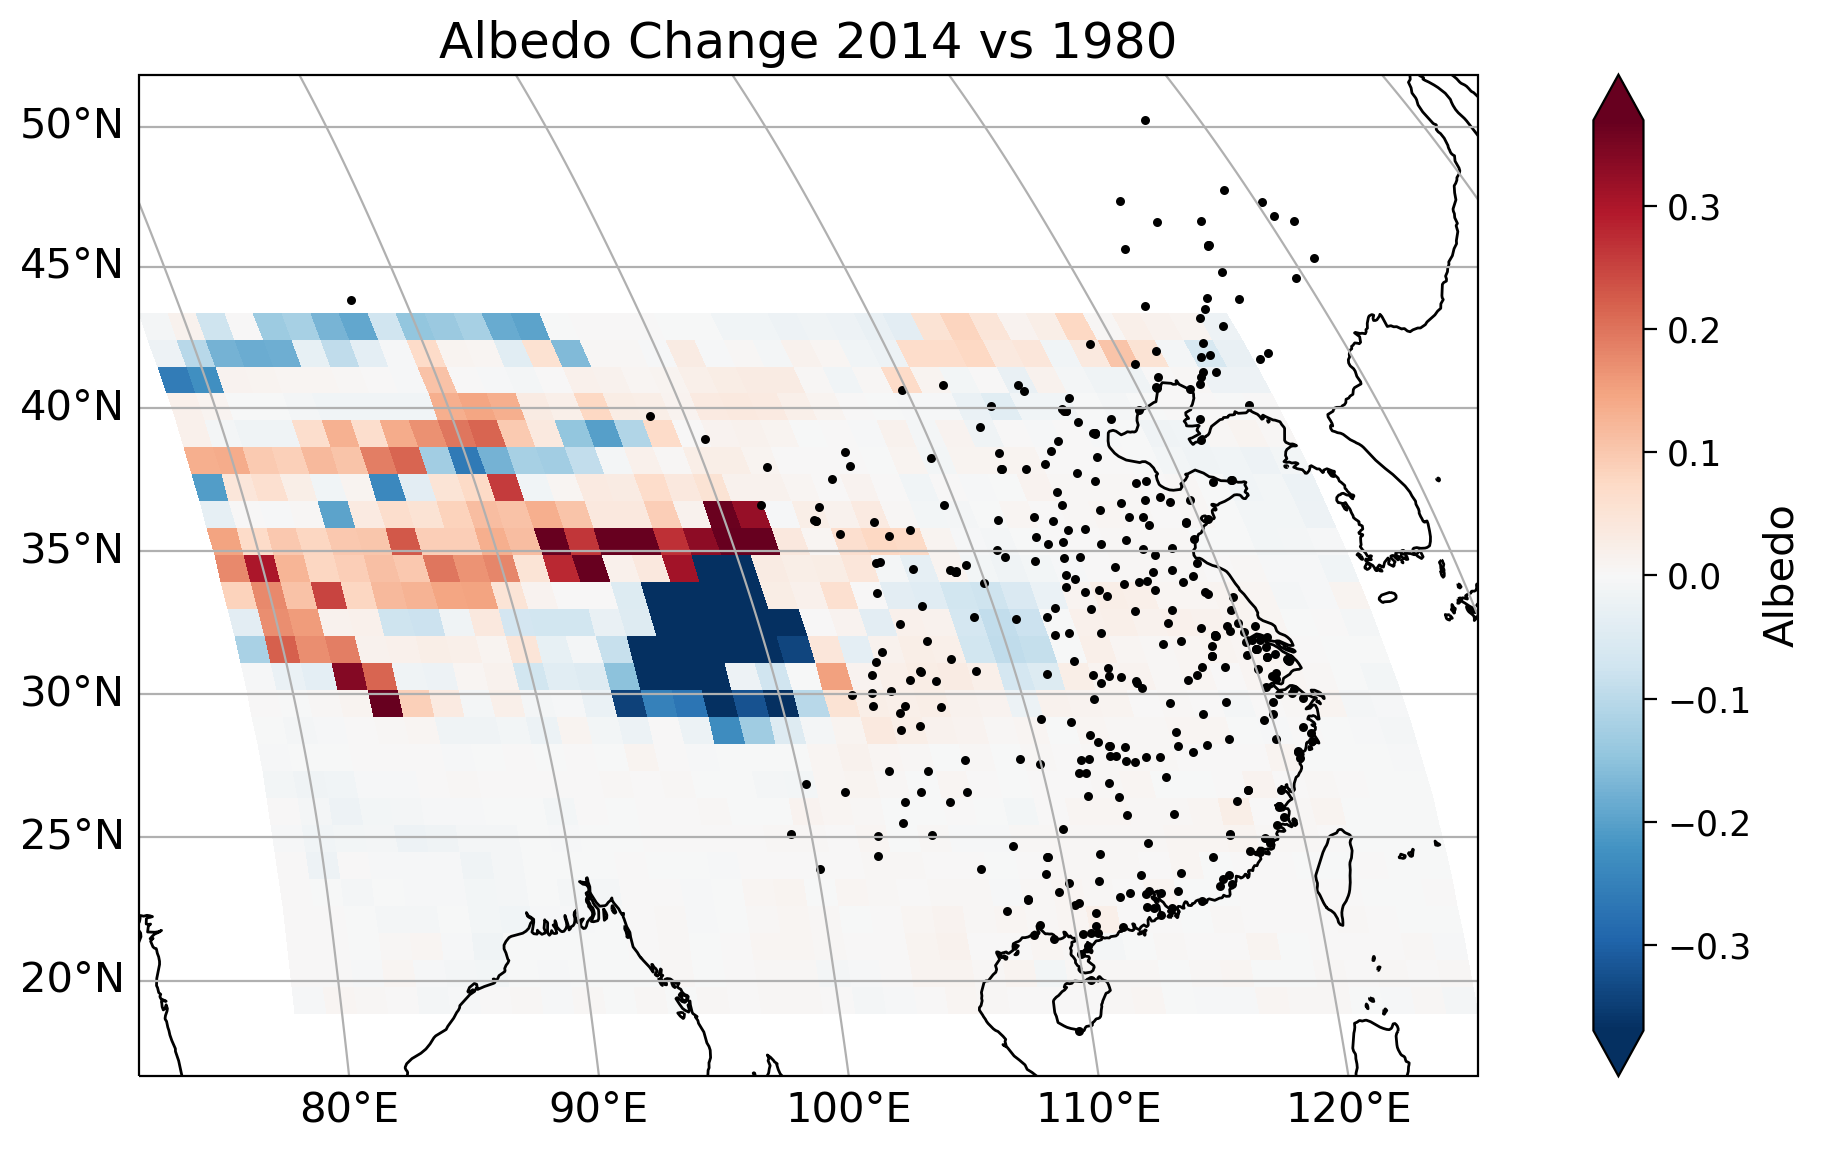

In [123]:
# trying to plot alb
albchina_1850 = alb_all.sel(x=slice(78,126), y=slice(19,43),time="1981-12-16").squeeze()

alb_diff = albchina_2014 - albchina_1850

fig, ax_albchina = plt.subplots(
    figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)
alb_diff.plot(ax=ax_albchina, transform=ccrs.PlateCarree(), robust=True)
ax_albchina.coastlines()
g = ax_albchina.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
g.top_labels = False
g.right_labels = False
plt.title('Albedo Change 2014 vs 1980')


import pandas

cities = pandas.read_csv('cn.csv')
cities

clat = cities.lat.to_numpy()
clon = cities.lng.to_numpy()
plt.scatter(clon, clat,  transform=ccrs.PlateCarree(), s=5, c='k')

# Shapefile

In [1]:
import geopandas
import rioxarray
import xarray
from shapely.geometry import mapping

/tmp/ipykernel_463/1970172620.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [2]:
# Get shapefile with maize production in Mato Grosso do Sul (MS)
fname = "/home/jovyan/shared-public/Zuniceratops_Ska_Staccato/shp/China_Provinces.shp"
sf = geopandas.read_file(fname)
sf.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
chirps_year.rio.set_spatial_dims(x_dim = "longitude", y_dim = "latitude", inplace = True)
chirps_year.rio.write_crs("epsg:4674", inplace = True)
sf = geopandas.read_file(fname, crs = "epsg:4674")
clipped = chirps_year.rio.clip(sf.geometry.apply(mapping), sf.crs, drop = True, all_touched = True)

In [ ]:
da = clipped.precip.sel(year =2022) -clipped.precip.sel(year =1990)

ax = sf.plot(alpha = 0.8, color = 'black')
da.plot(ax = ax, alpha = 0.9)

# Heatwaves

## P95

In [ ]:
# catrad = col.search(
#     source_id="CESM2",
#     variable_id=["rsds", "rsus", "tas"],
#     member_id="r1i1p1f1",
#     table_id="day",
#     grid_label="gn",
#     experiment_id=["historical"],
#     require_all_on=[
#         "source_id"
#     ],  # make sure that we only get models which have all of the above experiments
# )
# # create data tree
# dtrad = catrad.to_datatree(**kwargs)
# dsrad = dtrad["CMIP"]["NCAR"]["CESM2"]["historical"]["day"]["gn"].to_dataset().squeeze()
# tas_all = dsrad.tas

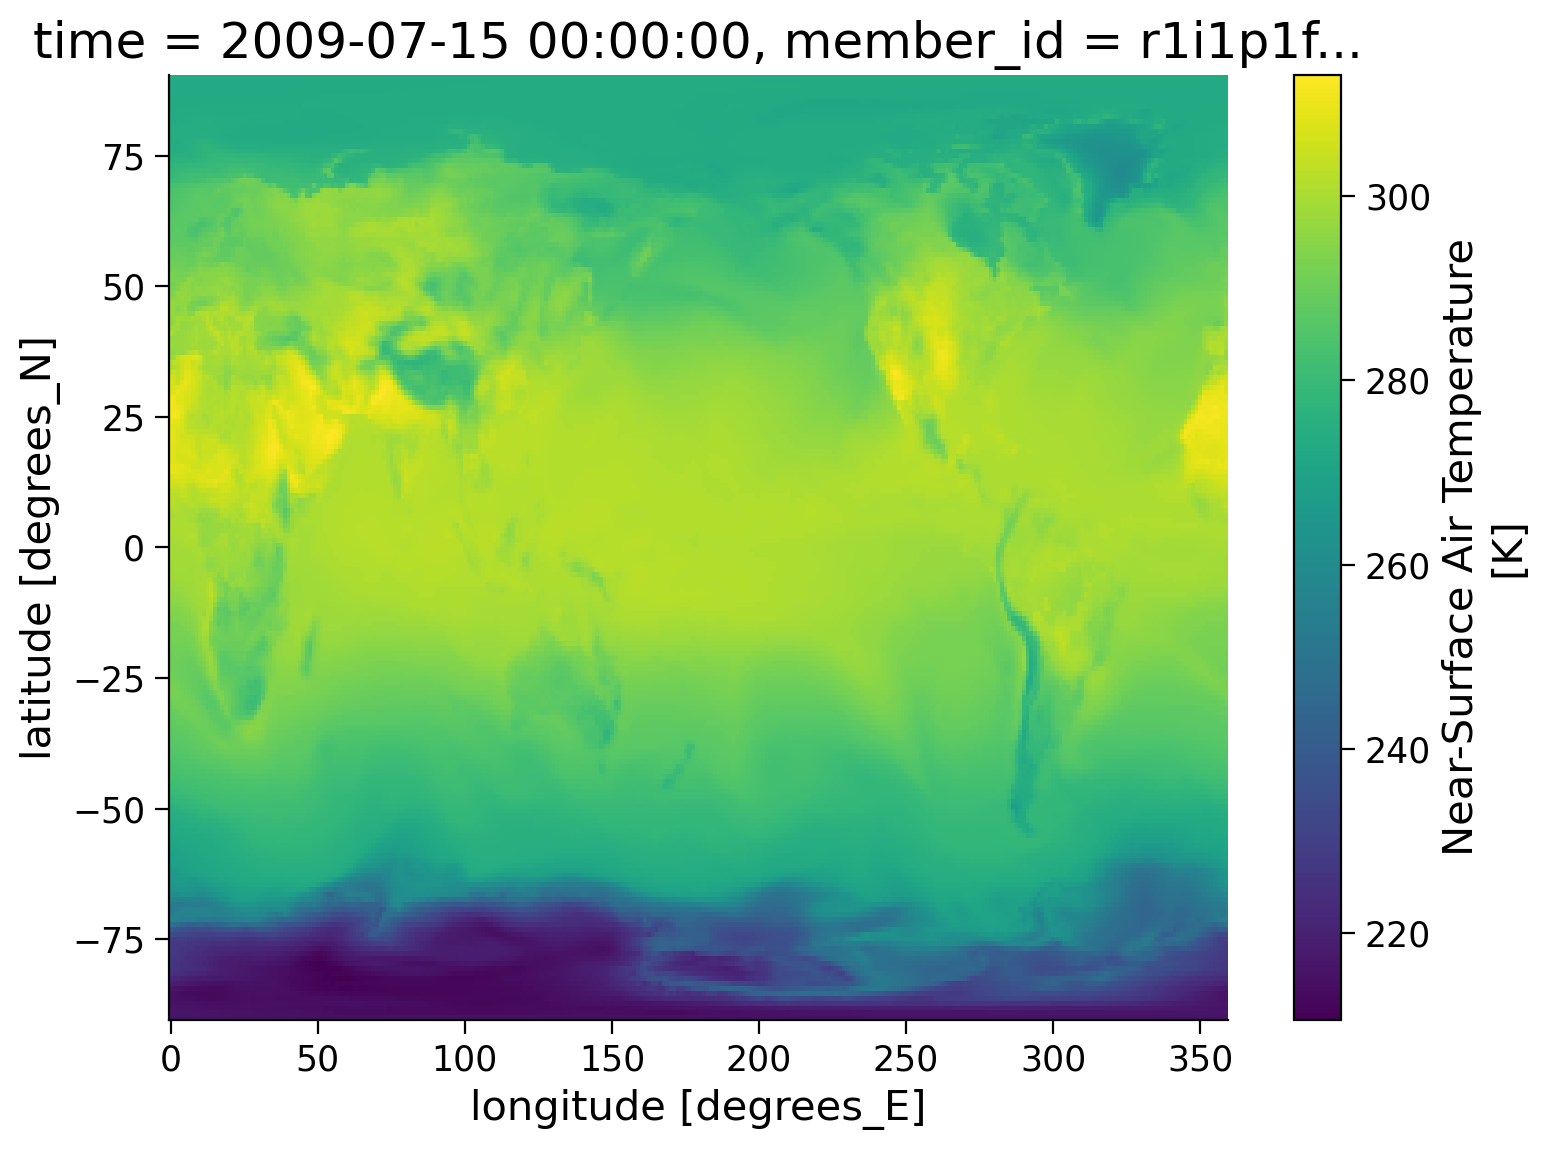

In [125]:
hoty = tas_all.sel(time = "2009-07-15")

hoty.plot()

In [52]:
tasch = tas_all.sel(x = slice(78, 126), y = slice(19,43)).squeeze()
tasch

<xarray.DataArray 'tas' (time: 60226, y: 26, x: 38)>
dask.array<getitem, shape=(60226, 26, 38), dtype=float32, chunksize=(397, 26, 38), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 19.32 20.26 21.2 22.15 ... 40.99 41.94 42.88
  * x               (x) float64 78.75 80.0 81.25 82.5 ... 122.5 123.8 125.0
  * time            (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    lon             (x, y) float64 78.75 78.75 78.75 78.75 ... 125.0 125.0 125.0
    lat             (x, y) float64 19.32 20.26 21.2 22.15 ... 40.99 41.94 42.88
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      day
    id:             tas
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas
    units:          K

In [22]:
ctasch = tasch - 273.15
ctasch.attrs = tasch.attrs
ctasch.attrs["units"] = "C"
ctasch

<xarray.DataArray 'tas' (time: 60226, y: 26, x: 38)>
dask.array<sub, shape=(60226, 26, 38), dtype=float32, chunksize=(397, 26, 38), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 19.32 20.26 21.2 22.15 ... 40.99 41.94 42.88
  * x               (x) float64 78.75 80.0 81.25 82.5 ... 122.5 123.8 125.0
  * time            (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    lon             (x, y) float64 78.75 78.75 78.75 78.75 ... 125.0 125.0 125.0
    lat             (x, y) float64 19.32 20.26 21.2 22.15 ... 40.99 41.94 42.88
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      day
    id:             tas
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas
    units:          C

In [64]:
# get baseline tas from 1980 to start of 2011
basetas = ctasch.sel(time = slice("1980-01-01", "2011-01-01"))
# using a subset of the area for speed; delete line below when ready
# basetas = basetas[:,0:10, 0:10]
P95 = np.percentile(basetas, 95, axis = 0)
P95

array([[37.2824173 , 36.61743927, 35.93432617, 35.28144073, 36.98509979,
        33.29446411, 31.22962189, 30.44763947, 30.12537384, 29.96659088,
        29.82033539, 29.52794647, 29.23735046, 30.74710846, 28.86148071,
        29.26530457, 29.41846466, 28.91973114, 29.53881073, 28.41526031,
        27.5304184 , 29.50080872, 31.31130981, 30.34985352, 30.78863525,
        30.89587402, 29.69153595, 29.4936142 , 29.47623444, 29.52113342,
        29.56362915, 29.63158417, 29.68664551, 29.64074707, 29.52645111,
        29.45646667, 29.4753418 , 29.38955688],
       [37.62171936, 37.56578827, 36.94155884, 37.29878998, 37.14854431,
        37.62541962, 35.26985931, 31.26517487, 30.39087677, 30.12911224,
        29.89328766, 29.59894562, 28.71380615, 31.04084015, 29.9098053 ,
        28.86898041, 28.96366882, 27.47917938, 28.49503326, 27.79079437,
        27.24075317, 29.26455688, 31.40884399, 30.38018036, 30.39819336,
        31.69042206, 29.89331055, 29.5892334 , 29.55622864, 29.56481171,
   

Text(0.5, 1.0, 'Tas on July 2014')

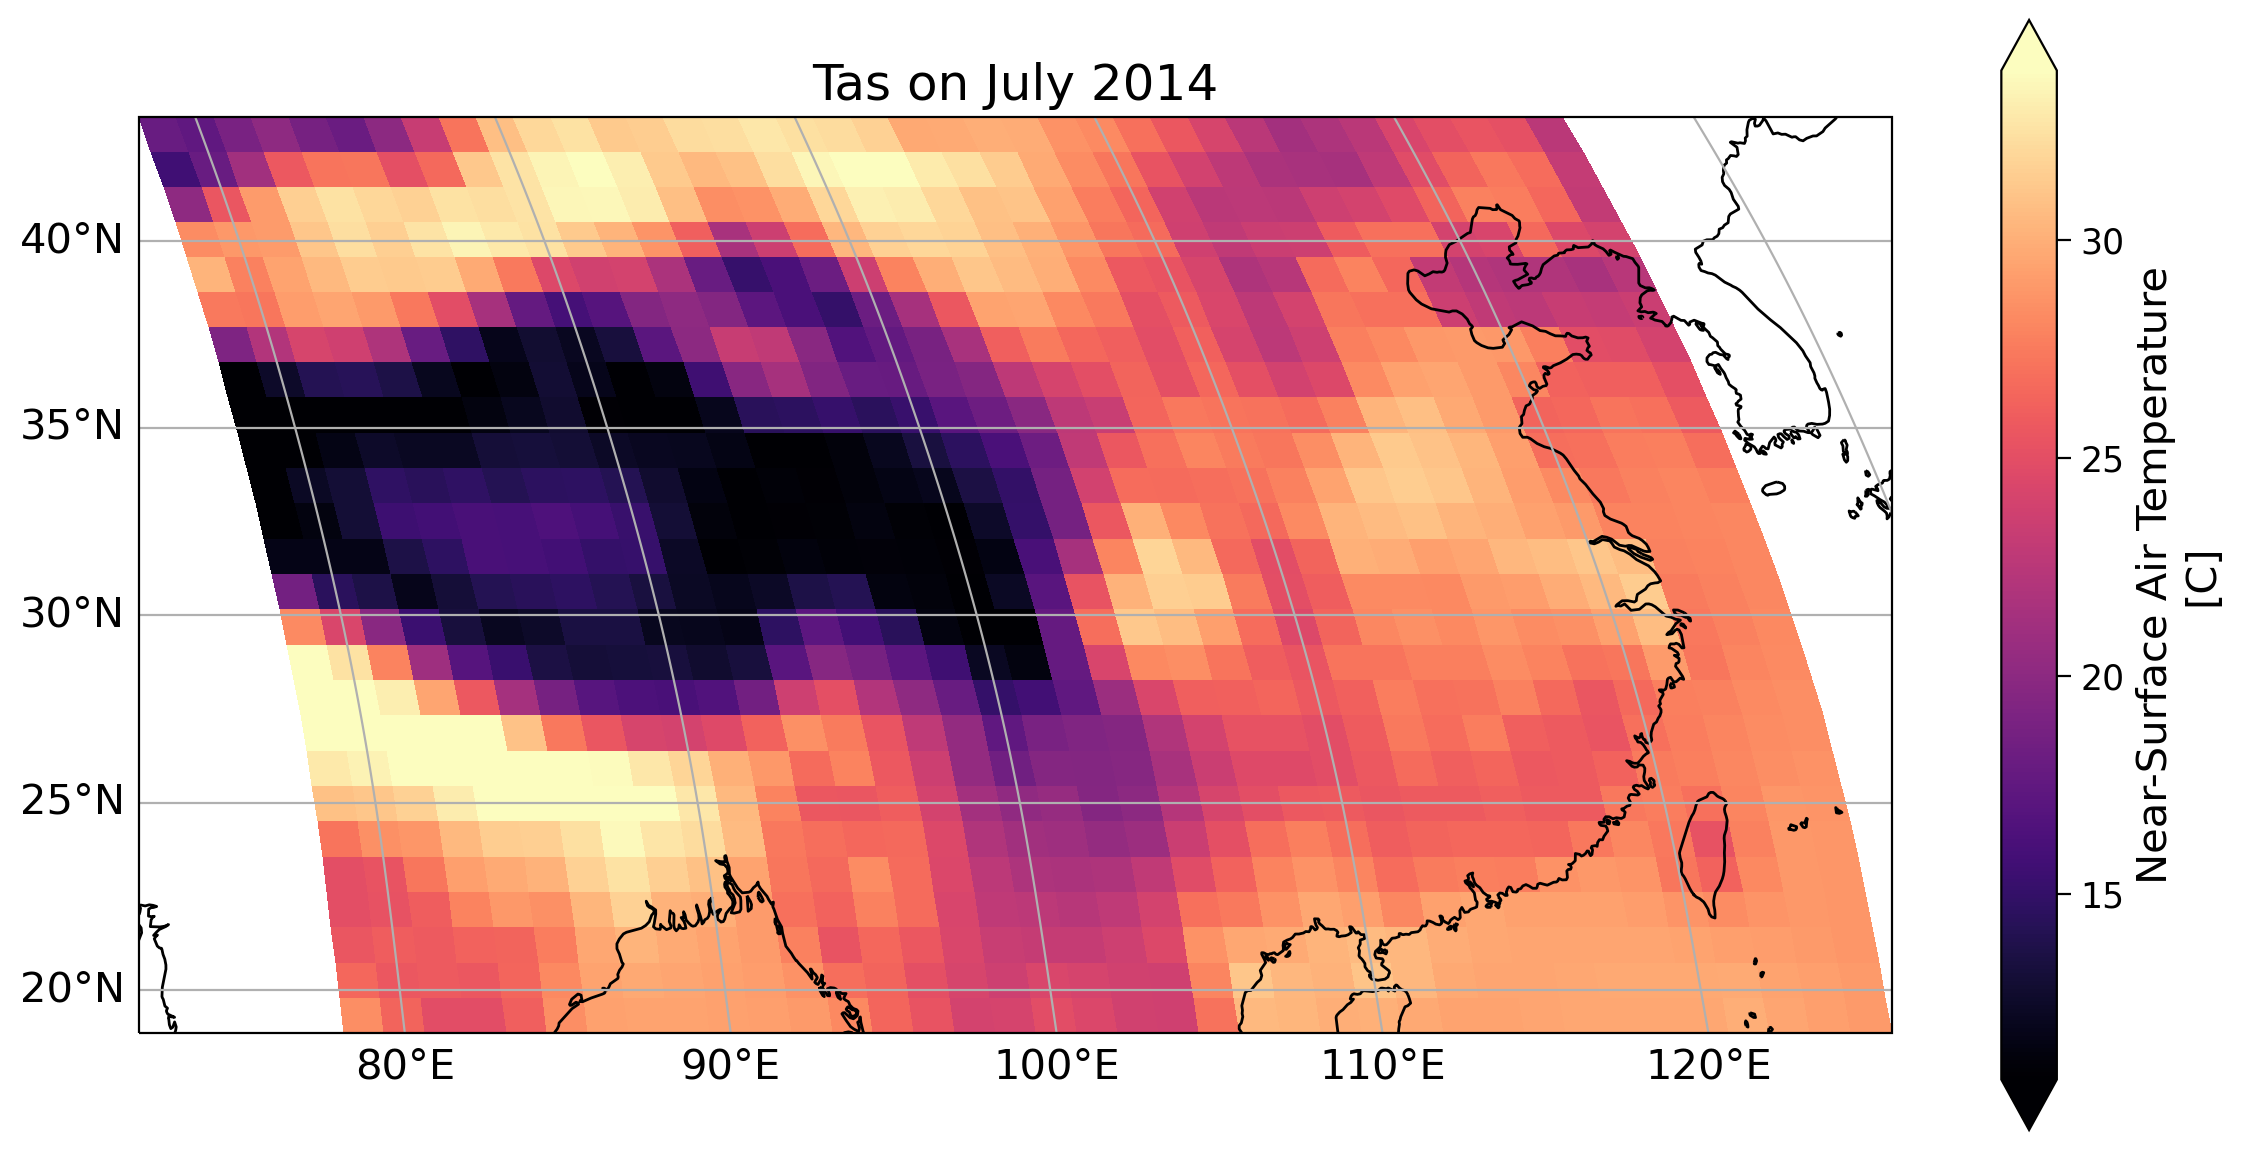

In [62]:
tas2017july = ctasch.sel(time="2014-07-16").squeeze()
fig, tasch_ax = plt.subplots(
    figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)
tas2017july.plot(ax=tasch_ax, transform=ccrs.PlateCarree(), cmap="magma", robust=True)
tasch_ax.coastlines()
g = tasch_ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
g.top_labels = False
g.right_labels = False
plt.title('Tas on July 2014')

In [24]:
# making sure there are no nans
tnans = pd.isna(basetas).sum()
anans = pd.isna(basetas).sum()
tnans, anans

(0, 0)

In [11]:
tasch[:,1,1]

<xarray.DataArray 'tas' (time: 60226)>
dask.array<getitem, shape=(60226,), dtype=float32, chunksize=(397,), chunktype=numpy.ndarray>
Coordinates:
    y               float64 20.26
    x               float64 80.0
  * time            (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    lon             float64 80.0
    lat             float64 20.26
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      day
    id:             tas
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas
    units:          K

In [25]:
P95

array([[37.2824173 , 36.61743927, 35.93432617, 35.28144073, 36.98509979,
        33.29446411, 31.22962189, 30.44763947, 30.12537384, 29.96659088],
       [37.62171936, 37.56578827, 36.94155884, 37.29878998, 37.14854431,
        37.62541962, 35.26985931, 31.26517487, 30.39087677, 30.12911224],
       [37.18323517, 37.38613892, 37.76926422, 38.52016449, 38.17300415,
        38.09780121, 38.10520935, 32.08717346, 30.80033112, 30.40584564],
       [36.24185181, 37.02744293, 37.42626953, 38.0356369 , 38.21764374,
        38.45111847, 38.77872467, 36.34397125, 33.39842987, 32.02835846],
       [35.62917328, 36.52111053, 37.21983337, 37.3694458 , 37.54846191,
        37.53578949, 39.30310822, 38.49461365, 36.03357697, 34.28755188],
       [37.18365479, 37.92582703, 38.2249527 , 38.18103027, 38.50053406,
        38.60496521, 39.53501129, 39.43634796, 37.20570374, 35.45155334],
       [37.64736176, 38.64790344, 39.46334076, 39.48635864, 39.6632309 ,
        39.50182343, 39.02358246, 38.49710083

Text(0.5, 1.0, '95th Percentile Temperature Value for Example Cell')

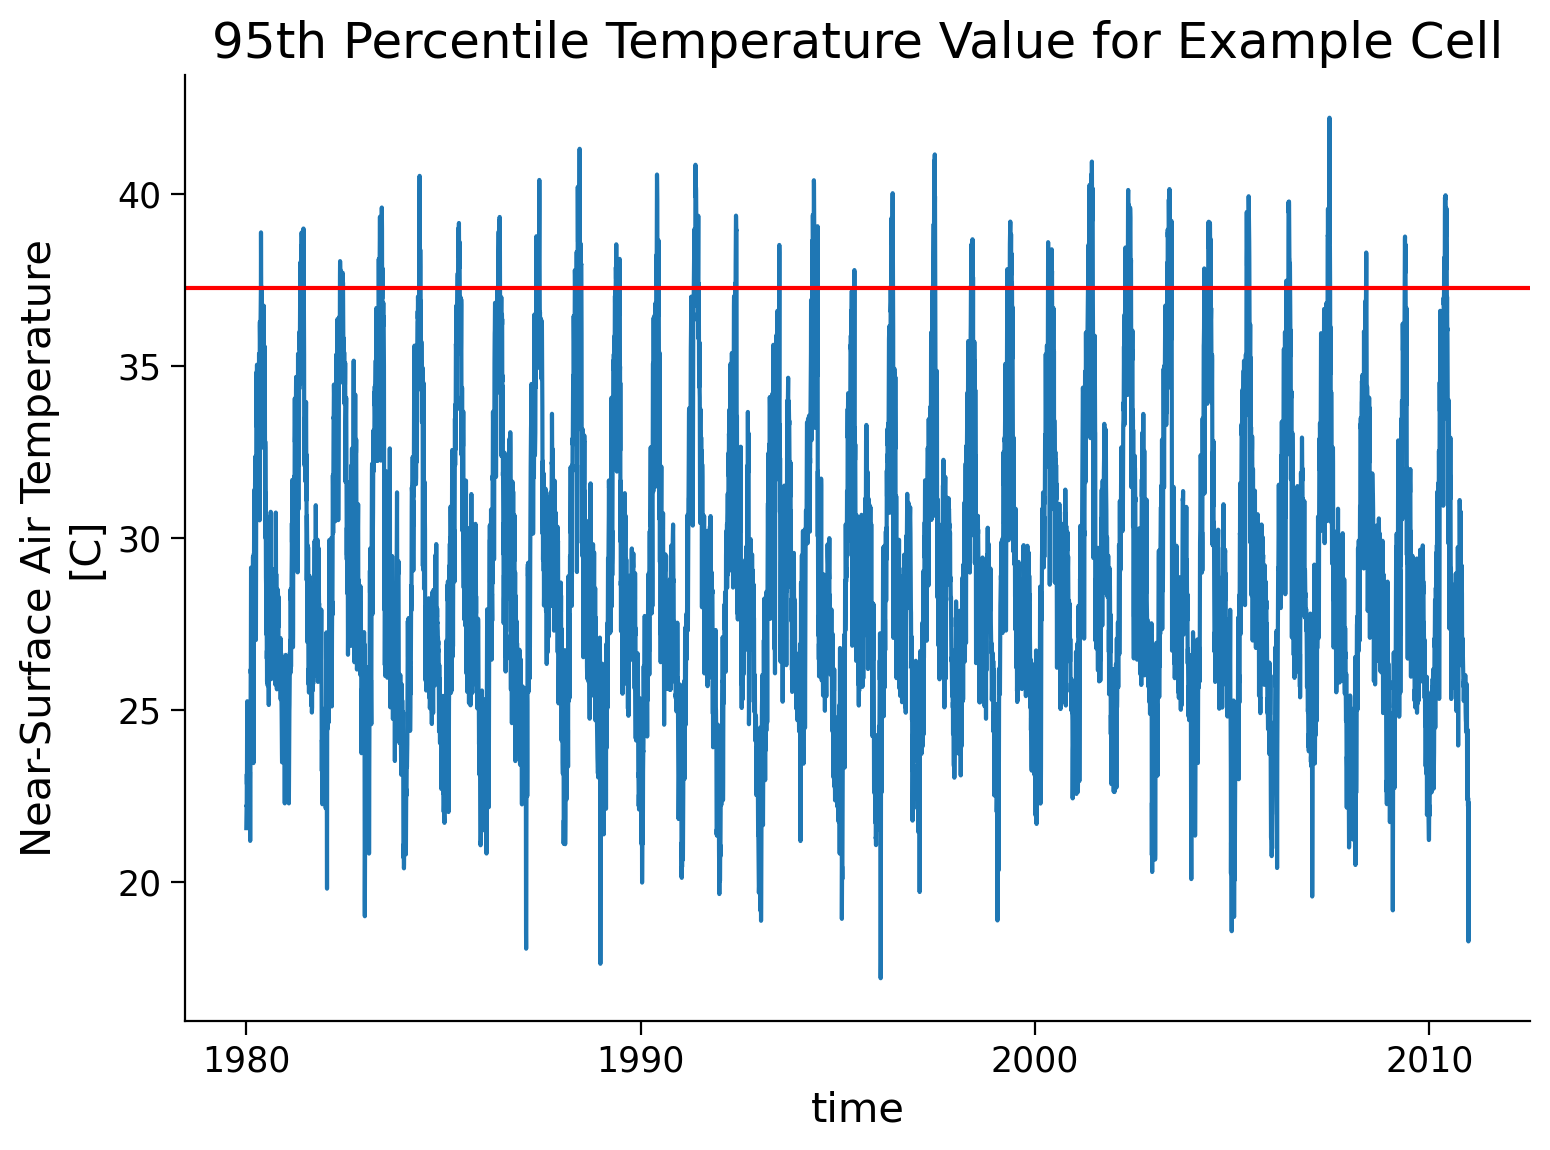

In [69]:
# plot timeseries for one cell
oneP95 = P95[0,0]
onets = basetas.sel(y = 19, x = 78, method = "nearest")
onets.plot()
plt.axhline(y=oneP95, color='r', linestyle='-')
plt.title('95th Percentile Temperature Value for Example Cell')

In [34]:
basetas.y

<xarray.DataArray 'y' (y: 10)>
array([19.319372, 20.26178 , 21.204188, 22.146597, 23.089005, 24.031414,
       24.973822, 25.91623 , 26.858639, 27.801047])
Coordinates:
  * y               (y) float64 19.32 20.26 21.2 22.15 ... 25.92 26.86 27.8
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
Attributes:
    axis:           Y
    bounds:         lat_bnds
    standard_name:  latitude
    title:          Latitude
    type:           double
    valid_max:      90.0
    valid_min:      -90.0
    units:          degrees_N

In [71]:
lats = basetas.y
lons = basetas.x
P95 = xr.DataArray(
    P95, coords=[lats, lons], dims=["lat", "lon"]
)
P95.attrs = basetas.attrs
P95.attrs["title"] = "Threshold Temperature"
P95.attrs["units"] = "C"
P95

<xarray.DataArray (lat: 26, lon: 38)>
array([[37.2824173 , 36.61743927, 35.93432617, 35.28144073, 36.98509979,
        33.29446411, 31.22962189, 30.44763947, 30.12537384, 29.96659088,
        29.82033539, 29.52794647, 29.23735046, 30.74710846, 28.86148071,
        29.26530457, 29.41846466, 28.91973114, 29.53881073, 28.41526031,
        27.5304184 , 29.50080872, 31.31130981, 30.34985352, 30.78863525,
        30.89587402, 29.69153595, 29.4936142 , 29.47623444, 29.52113342,
        29.56362915, 29.63158417, 29.68664551, 29.64074707, 29.52645111,
        29.45646667, 29.4753418 , 29.38955688],
       [37.62171936, 37.56578827, 36.94155884, 37.29878998, 37.14854431,
        37.62541962, 35.26985931, 31.26517487, 30.39087677, 30.12911224,
        29.89328766, 29.59894562, 28.71380615, 31.04084015, 29.9098053 ,
        28.86898041, 28.96366882, 27.47917938, 28.49503326, 27.79079437,
        27.24075317, 29.26455688, 31.40884399, 30.38018036, 30.39819336,
        31.69042206, 29.89331055, 29.5892334 , 29.55622864, 29.56481171,
        29.61273193, 29.64191437, 29.67204285, 29.63249969, 29.55217743,
        29.49723816, 29.45831299, 29.37218475],
       [37.18323517, 37.38613892, 37.76926422, 38.52016449, 38.17300415,
        38.09780121, 38.10520935, 32.08717346, 30.80033112, 30.40584564,
        30.1286087 , 29.12320709, 28.98529053, 32.12941742, 30.68175507,
        28.8639679 , 28.24370575, 27.68945312, 28.05183411, 27.60718536,
...
        28.9936676 , 28.45861816, 28.17453003, 26.56182098, 25.67947388,
        24.55898285, 23.1568985 , 22.41757202, 22.29592133, 22.66120148,
        24.12407684, 24.77081299, 25.47429657, 26.2260437 , 26.5319519 ,
        26.233284  , 25.09126282, 24.13095856],
       [14.41719055, 16.23119354, 19.66934967, 22.84869385, 24.41362   ,
        25.1065979 , 25.03610229, 27.10894012, 29.41371918, 31.20343781,
        31.65956879, 31.82820129, 30.11977386, 27.9526825 , 26.93723297,
        27.75052643, 29.34676361, 30.50481415, 30.1469574 , 30.04246521,
        29.12913513, 29.00170135, 27.90722656, 27.08552551, 26.10295105,
        25.10188293, 23.93206787, 23.28360748, 22.60814667, 21.96580505,
        21.82658386, 22.6184082 , 23.4959259 , 24.99169922, 25.93310547,
        26.24411774, 25.57229614, 24.27089691],
       [17.6026001 , 17.21933746, 18.10280609, 19.23392487, 17.94499969,
        16.99705505, 19.21594238, 23.83866882, 27.72644043, 29.61904907,
        30.41830444, 30.14847565, 28.59388733, 28.42919159, 28.52748108,
        28.7342453 , 29.67598724, 29.83506012, 29.1852417 , 28.11309814,
        27.18041229, 27.31703949, 27.7382431 , 27.87024689, 27.44688416,
        26.78913116, 25.76113892, 24.9670639 , 24.09295654, 22.50896454,
        21.21326447, 21.5458374 , 23.39633942, 25.07694244, 25.69963074,
        25.97954559, 25.72978973, 24.9484787 ]])
Coordinates:
  * lat      (lat) float64 19.32 20.26 21.2 22.15 ... 40.05 40.99 41.94 42.88
  * lon      (lon) float64 78.75 80.0 81.25 82.5 ... 121.2 122.5 123.8 125.0
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      day
    id:             tas
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Threshold Temperature
    type:           real
    variable_id:    tas
    units:          C

Text(0.5, 1.0, '95th Percentile for the Selected Region')

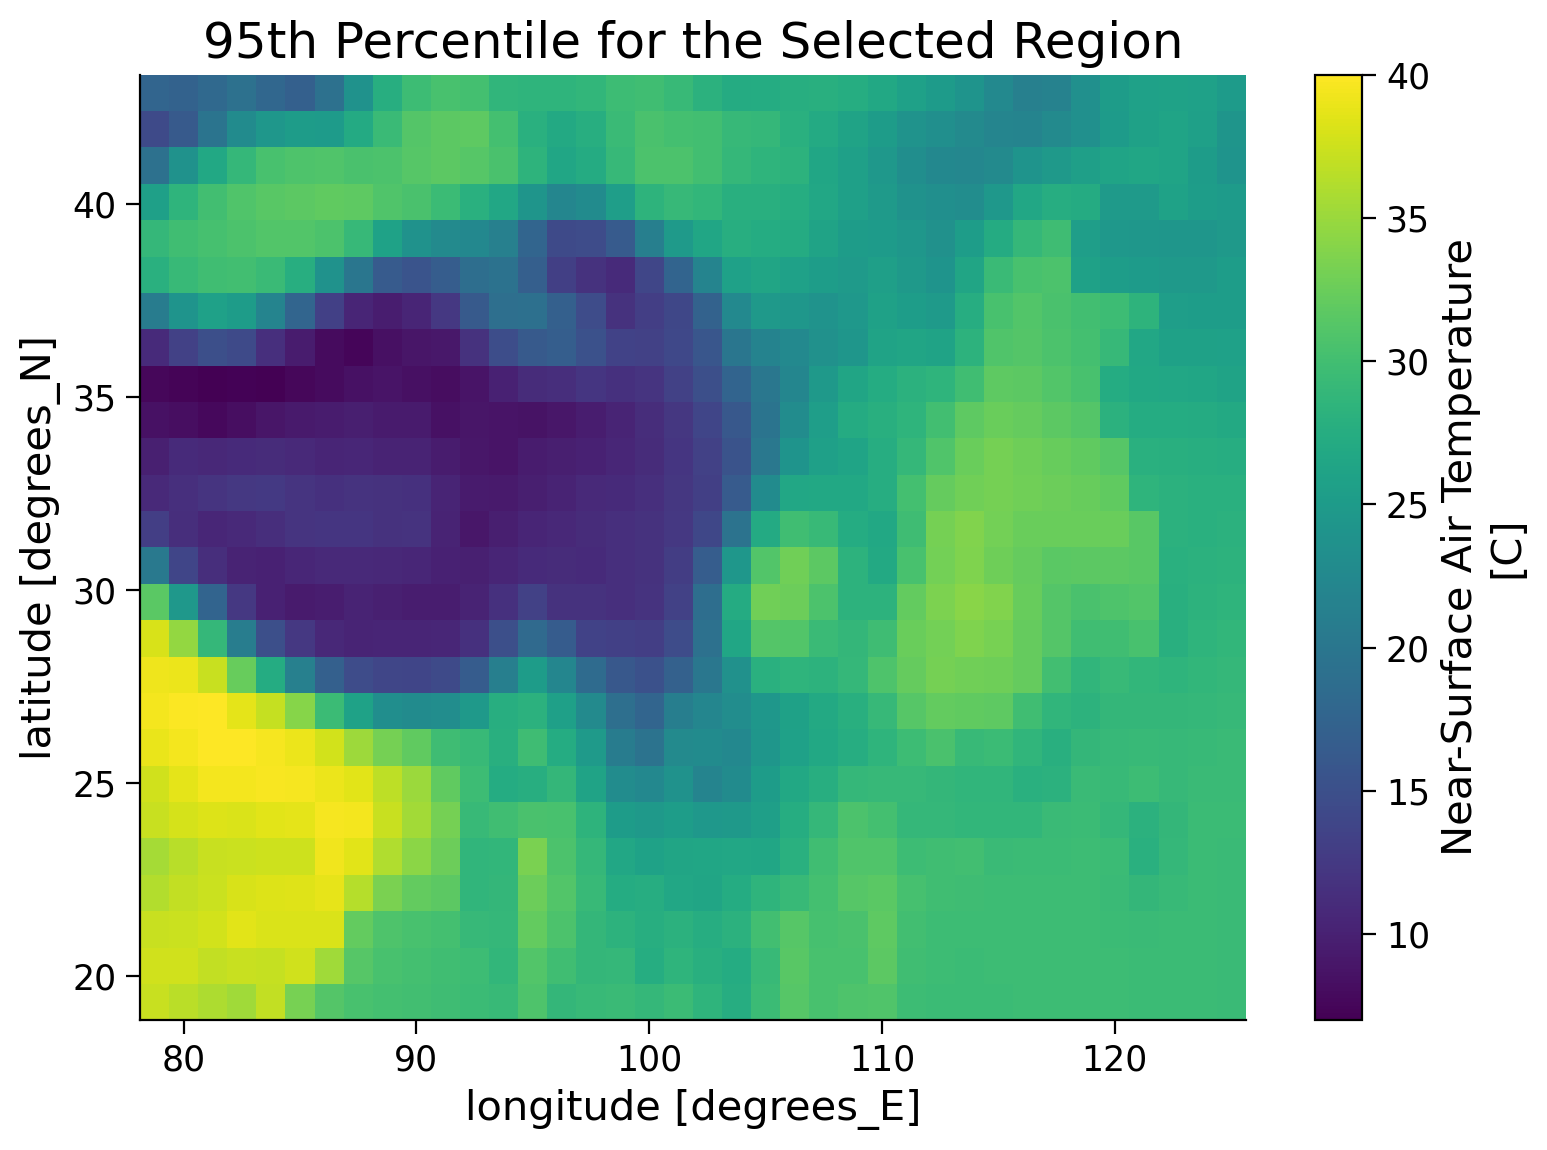

In [72]:
fig = P95.plot()
plt.title("95th Percentile for the Selected Region")

In [109]:
# find where the P95 threshold was exceeded
# here basetas should be replaced by the whole timeseries
seltime1 = ctasch.sel(time = slice("2005-01-01", "2015-01-01"))
seltime2 = ctasch.sel(time = slice("1995-01-01", "2005-01-01"))
difftas1 = seltime1 - P95.values[None, :, :]
difftas2 = seltime2 - P95.values[None, :, :]
difftas1

<xarray.DataArray 'tas' (time: 3651, y: 26, x: 38)>
dask.array<sub, shape=(3651, 26, 38), dtype=float64, chunksize=(397, 26, 38), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 19.32 20.26 21.2 22.15 ... 40.99 41.94 42.88
  * x               (x) float64 78.75 80.0 81.25 82.5 ... 122.5 123.8 125.0
  * time            (time) object 2005-01-01 00:00:00 ... 2015-01-01 00:00:00
    lon             (x, y) float64 78.75 78.75 78.75 78.75 ... 125.0 125.0 125.0
    lat             (x, y) float64 19.32 20.26 21.2 22.15 ... 40.99 41.94 42.88
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan

In [100]:
# # find number of consecutive days where threshold was exceeded
# # ts -> timeseries of current location 
# # returns a vector (nd) of length of ts with # of days: eg, ts1,ts2,ts3 are True, while ts4 is False, then nd1=3
# def consecdays(ts,maxdays):
#     nd = np.zeros_like(ts)
#     for d,hot in enumerate(ts):
#         count = 0
#         for i in range(0,maxdays):
#             if hot:
#                 count +=1
#             else:
#                 count = 0
#             nd[d+i] = count
#     return nd

# should have googled it sooner? https://stackoverflow.com/a/75234193

def consecdays(ts):
    boolts = ts.values > 0
    cs = boolts.cumsum()
    steps = np.maximum.accumulate(cs - np.where(boolts, cs, 0))
    return cs - steps

def maxdays(ts):
    return consecdays(ts).max()

# quick tests
# consecdays(xr.DataArray([0, 0, 1, 0, 1, 1, 1, 0, 1, 0]))
maxdays(difftas2[500:1000,0,0])

21

In [ ]:
# filter based on mindays
def meetsduration(ts, mindays):
    return 1

In [ ]:
# iterate over each (lon, lat)

In [ ]:
# summary statistics?
# frequency: how many times were hw detected in the studied time frame?
# mean duration

In [ ]:
# now, hw intensity 

In [ ]:
# I guess use the outputs of consecdays/meetsduration to filter difftas, where values are > 0
# Then find the mean of these values

In [114]:
diffsel = difftas1.sel(x = slice(110,120), y = slice(20,30))
diffvals = diffsel.values
dms = diffvals.shape
rows = dms[1]
cols = dms[2]
maxdays = np.zeros((cols, rows))
for c in range(0,cols):
    for r in range(0,rows):
        maxdays[c,r] = consecdays(difftas1[:,c,r]).max()
maxdays

array([[23., 23., 19., 24., 24., 18., 24., 49., 49., 48., 47.],
       [25., 22., 22., 26., 25., 17., 17., 25., 49., 48., 47.],
       [25., 29., 29., 30., 30., 25., 17., 18., 40., 43., 43.],
       [26., 30., 30., 29., 29., 29., 22., 17., 17., 25., 37.],
       [31., 31., 30., 31., 30., 28., 27., 17., 16., 20., 30.],
       [32., 32., 30., 30., 29., 28., 29., 23., 15., 17., 16.],
       [32., 33., 33., 29., 28., 27., 28., 22., 20., 15., 12.],
       [35., 35., 36., 28., 27., 27., 26., 16., 16., 14., 11.],
       [34., 40., 28., 27., 28., 22., 15., 17., 14., 14., 13.]])

In [ ]:
lats2 = diffsel.y
lons2 = diffsel.x
maxdaysxr = xr.DataArray(
    maxdaysxr, coords=[lats2, lons2], dims=["lat", "lon"]
)
maxdaysxr.attrs = basetas.attrs
maxdaysxr.attrs["title"] = "Maximum Heatwave Duration"
maxdaysxr.attrs["units"] = "days"
maxdaysxr

In [ ]:
fig, ax_maxd = plt.subplots(
    # figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)

maxdaysxr.plot(ax = ax_maxd)
ax_maxd.coastlines()
g = ax_maxd.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
g.top_labels = False
g.right_labels = False
plt.title('Tas on July 2014')


In [86]:
difftas1.values.shape[1]

26

## From Matteo's

In [ ]:
import pandas

cities = pandas.read_csv('cn.csv')
cities
lat = cities.lat.to_numpy()
lon = cities.lng.to_numpy()

cat = col.search(
    variable_id=["rsds", "rsus","tas"],
    member_id="r1i1p1f1",
    grid_label="gn",
    source_id='TaiESM1',
    table_id='day',
    experiment_id=["historical","ssp585"],  # add scenarios if interested in projection
    require_all_on=[
        "source_id", "experiment_id"],  # make sure that we only get models which have all of the above experiments
)

# # # convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt = cat.to_datatree(**kwargs)

ds = dt["TaiESM1"]["historical"].to_dataset()
ds["alb"] = ds.rsus / (ds.rsds)

alb_diff = ds['alb'].sel(time='2014-12-28').squeeze() - ds['alb'].sel(time='1981-01-01').squeeze()
alb_diff.sel(x=slice(lon.min(),lon.max()),y=slice(lat.min(),lat.max()))


fig, ax_present = plt.subplots(
    figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)

# dt['TaiESM1']['historical'].ds.tas.sel(x=23, y=113, method='nearest').squeeze().rolling(time=10).mean().plot()
alb_diff = ds['alb'].sel(time='2014-12-28').squeeze() - ds['alb'].sel(time='1981-01-01').squeeze()

tas_china = alb_diff.sel(x=slice(lon.min(),lon.max()),y=slice(lat.min(),lat.max()))
tas_present = tas_china.squeeze()
tas_present.plot(ax=ax_present, transform=ccrs.PlateCarree(),  robust=True)
ax_present.coastlines()
plt.scatter(lon, lat,  transform=ccrs.PlateCarree(), s=5, c='k')

## From Bex's

In [ ]:
tas_china = ds.sel(x=slice(78,126),y=slice(19,43))
tas_china_2013 = tas_china.sel(time="2013-07-01T00").squeeze()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[8, 4], subplot_kw={"projection": ccrs.Robinson()})

#plot the model data
tas_china_2013.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    x="x",
    y="y",
    cmap="magma",
    robust=True,
)

g = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
g.top_labels = False
g.right_labels = False
ax.coastlines(linewidth = 3, color = 'gray')

ax.set_title(""); 